In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
 
from glob import glob
from PIL import Image

from sklearn.model_selection import train_test_split
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from keras import layers
from functools import partial

from sklearn.metrics import f1_score

AUTO = tf.data.experimental.AUTOTUNE

<h4>let's read the number of images</h4>

In [2]:
train_images = glob("data/train/**/*.jpg", recursive=True)
total_train_images = len(train_images)
print("Total Train images:", total_train_images)

Total Train images: 2637


<h4>Replace backslash with forward slash to avoid unexpected errors for train images</h4>

In [3]:
train_images = [path.replace('\\', '/') for path in train_images]
train_df = pd.DataFrame({'filepath': train_images})
train_df['label'] = train_df['filepath'].str.split('/', expand=True)[2]
train_df.head(2000)

,filepath,label
0,data/train/benign/100.jpg,benign
1,data/train/benign/1000.jpg,benign
2,data/train/benign/1001.jpg,benign
3,data/train/benign/1002.jpg,benign
4,data/train/benign/1004.jpg,benign
...,...,...
1995,data/train/malignant/279.jpg,malignant
1996,data/train/malignant/28.jpg,malignant
1997,data/train/malignant/280.jpg,malignant
1998,data/train/malignant/281.jpg,malignant


<h4>let's convert the labels to 0 and 1. this will enhance labeling endcodings for train images</h4>

In [4]:
train_df['label_bin'] = np.where(train_df['label'].values == 'malignant', 1, 0)
train_df.head(2600)

,filepath,label,label_bin
0,data/train/benign/100.jpg,benign,0
1,data/train/benign/1000.jpg,benign,0
2,data/train/benign/1001.jpg,benign,0
3,data/train/benign/1002.jpg,benign,0
4,data/train/benign/1004.jpg,benign,0
...,...,...,...
2595,data/train/malignant/958.jpg,malignant,1
2596,data/train/malignant/959.jpg,malignant,1
2597,data/train/malignant/96.jpg,malignant,1
2598,data/train/malignant/960.jpg,malignant,1


<br>

<h4>Percentage of Benign and Malignant images for train images</h4>

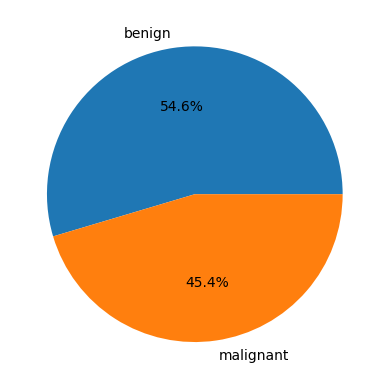

In [5]:
x = train_df['label'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()

<br>

<h4>Script for Image Samples of train images</h4>

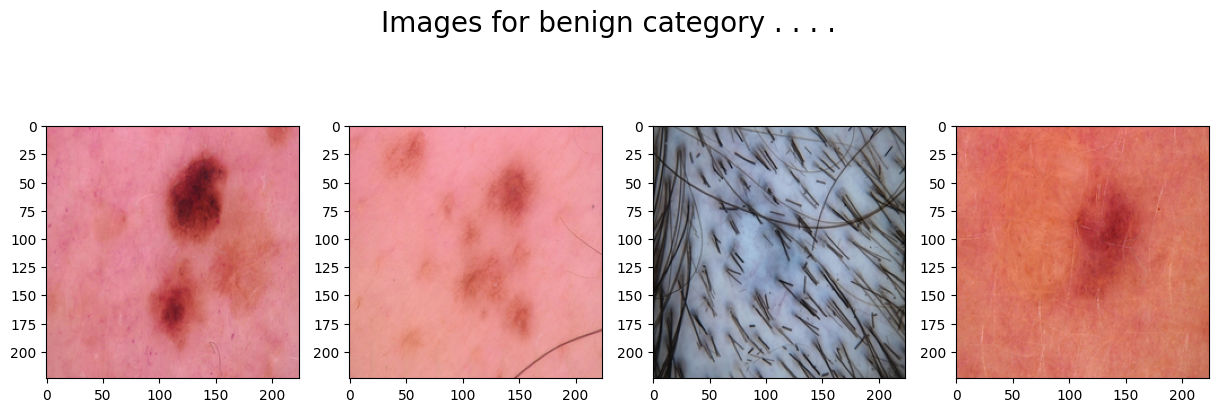

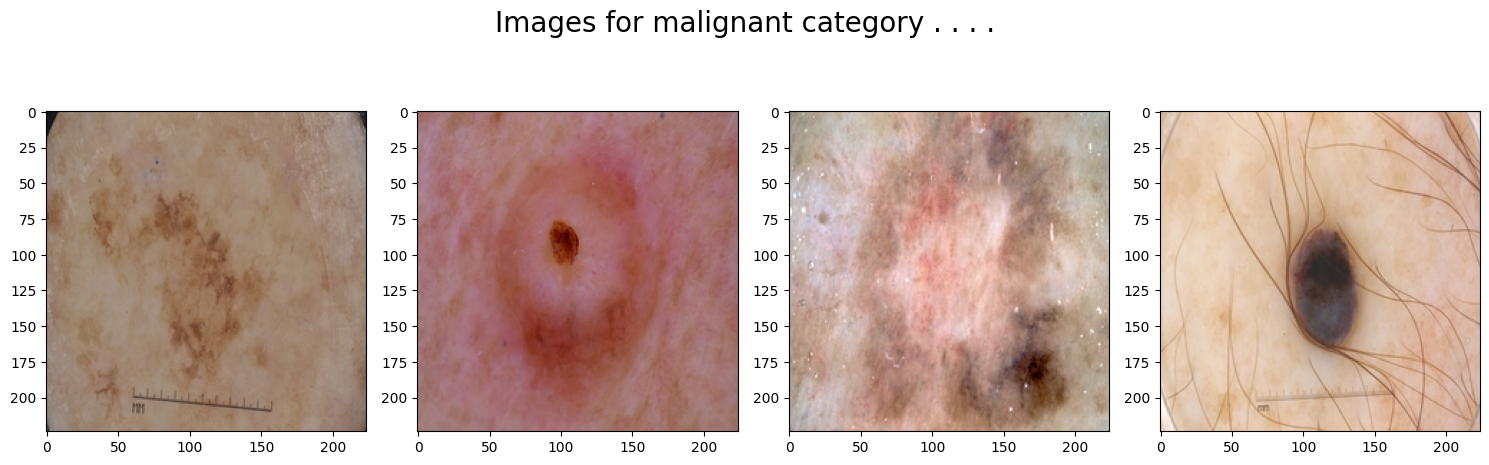

In [6]:
for cat in train_df['label'].unique():
    temp = train_df[train_df['label'] == cat]

    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = train_df.iloc[index]

        image_path = data[0]

        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()


<br>

<h4>Split datasets into trianing and testing</h4>

In [7]:
features = train_df['filepath']
target = train_df['label']
 
X_train, X_test, Y_train, Y_test = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, Y_test.shape

((2241,), (396,))

<br>

<h4>Function to decode images</h4>

In [8]:
def decode_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    
    # Classify labels
    if label == 'benign':
        Label = 0
    else:
        Label = 1
    
    return img, Label

<br>

<h4>Let's Build image input pipeline</h4>

In [9]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)
 
test_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_test, Y_test))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

<br>

<h4>Model Development</h4>

In [10]:
pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)
 
for layer in pre_trained_model.layers:
    layer.trainable = False

In [11]:
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)
 
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
 
model = Model(inputs, outputs)

In [12]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [13]:
f1_score_metric = F1Score()

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer='adam',
    metrics=['accuracy','AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score_metric]
)

In [14]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=5,
                    verbose=1)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 0.5444 - accuracy: 0.7452 - auc: 0.8163 - precision_1: 0.7028 - recall_1: 0.7589 - f1_score: 0.7298

C:\skin-cancer-detection\venv\lib\site-packages\keras\engine\training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


71/71 [==============================] - 21s 281ms/step - loss: 0.5444 - accuracy: 0.7452 - auc: 0.8163 - precision_1: 0.7028 - recall_1: 0.7589 - f1_score: 0.7298 - val_loss: 0.6638 - val_accuracy: 0.6869 - val_auc: 0.8579 - val_precision_1: 0.9014 - val_recall_1: 0.3536 - val_f1_score: 0.5079
Epoch 2/5
71/71 [==============================] - 20s 283ms/step - loss: 0.4787 - accuracy: 0.7724 - auc: 0.8548 - precision_1: 0.7360 - recall_1: 0.7766 - f1_score: 0.7557 - val_loss: 0.5516 - val_accuracy: 0.6970 - val_auc: 0.8846 - val_precision_1: 0.8506 - val_recall_1: 0.4088 - val_f1_score: 0.5522
Epoch 3/5
71/71 [==============================] - 20s 285ms/step - loss: 0.4438 - accuracy: 0.7791 - auc: 0.8732 - precision_1: 0.7446 - recall_1: 0.7805 - f1_score: 0.7621 - val_loss: 0.7042 - val_accuracy: 0.6995 - val_auc: 0.8940 - val_precision_1: 0.9559 - val_recall_1: 0.3591 - val_f1_score: 0.5221
Epoch 4/5
71/71 [==============================] - 21s 293ms/step - loss: 0.4265 - accuracy:

In [15]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,auc,precision_1,recall_1,f1_score,val_loss,val_accuracy,val_auc,val_precision_1,val_recall_1,val_f1_score
0,0.544365,0.745203,0.816308,0.702826,0.758858,0.729768,0.663786,0.686869,0.857883,0.901408,0.353591,0.507936
1,0.478662,0.772423,0.854787,0.736007,0.776575,0.755747,0.551557,0.696970,0.884633,0.850575,0.408840,0.552239
2,0.443770,0.779116,0.873187,0.744601,0.780512,0.762134,0.704223,0.699495,0.894025,0.955882,0.359116,0.522088
3,0.426540,0.788934,0.880315,0.749311,0.803150,0.775297,1.335852,0.580808,0.867545,1.000000,0.082873,0.153061
4,0.413062,0.799197,0.889172,0.762037,0.810039,0.785305,1.228793,0.575758,0.882410,0.933333,0.077348,0.142857


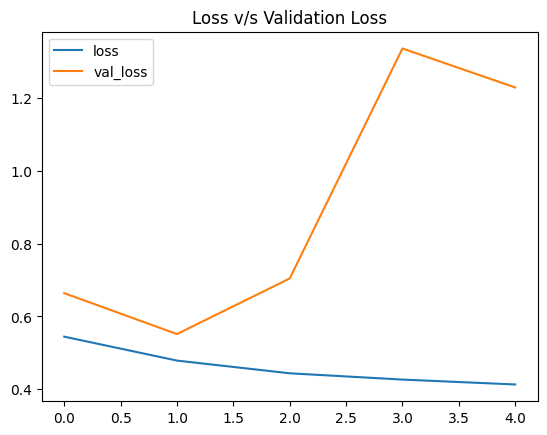

In [16]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

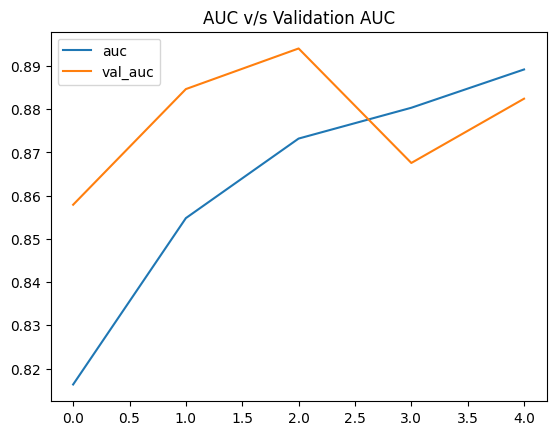

In [17]:
hist_df['auc'].plot()
hist_df['val_auc'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()